<a href="https://colab.research.google.com/github/Spandana5618/cs666student/blob/main/Copy_of_CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

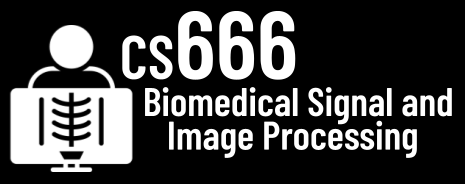
# Assignment 6

In [4]:
# NAME: SPANDANA SUSAL

In [5]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [6]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-25 02:14:46--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.3’

mito.npz.3          100%[===================>]  35.87M   229MB/s    in 0.2s    

2023-04-25 02:14:46 (229 MB/s) - ‘mito.npz.3’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [10]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

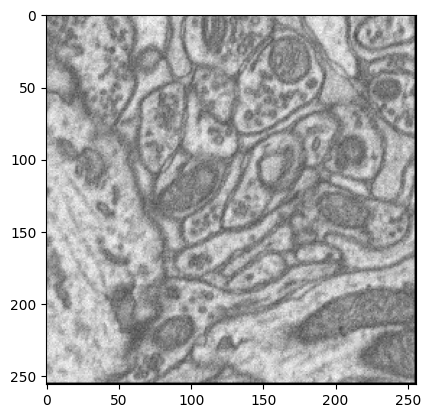

In [11]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
plt.imshow(images[0], cmap='gray')
plt.show()

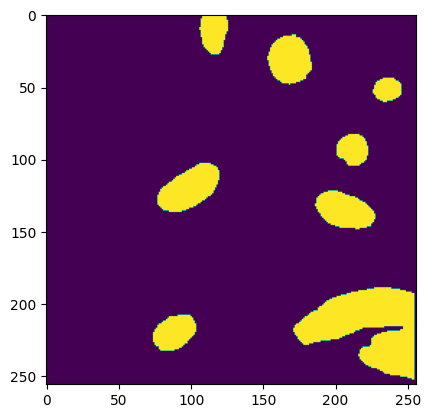

In [12]:
# TODO: Show the first mask.
plt.imshow(masks[0])
plt.show()

## 1. SAM in AUTO mode (15 points)

In [13]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [15]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [16]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


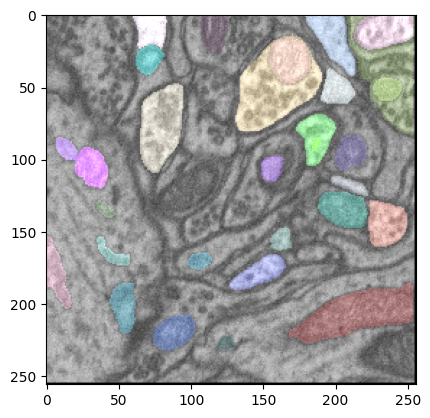

In [17]:
imshow( mh.imread('first_output.png') )

In [18]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: yes 

In [19]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

vit_h model already exists as 'vit_h.pth'. Skipping download.


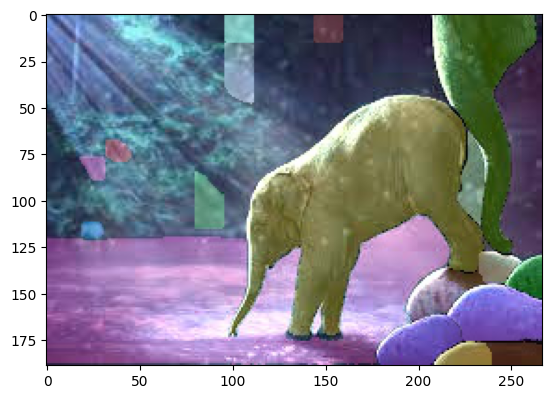

In [20]:
# TODO: YOUR CODE
results_2 = SegAutoMaskPredictor().image_predict(
    source="download.jpeg",
    model_type="vit_h", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="second_output.jpeg",
    show=False,
    save=True,
)
imshow( mh.imread('second_output.jpeg') )


     

In [21]:
# TODO: Does SAM work well on your example?
# TODO: yes

## 2. Train a U-Net classifier from scratch (50 points)


In [22]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

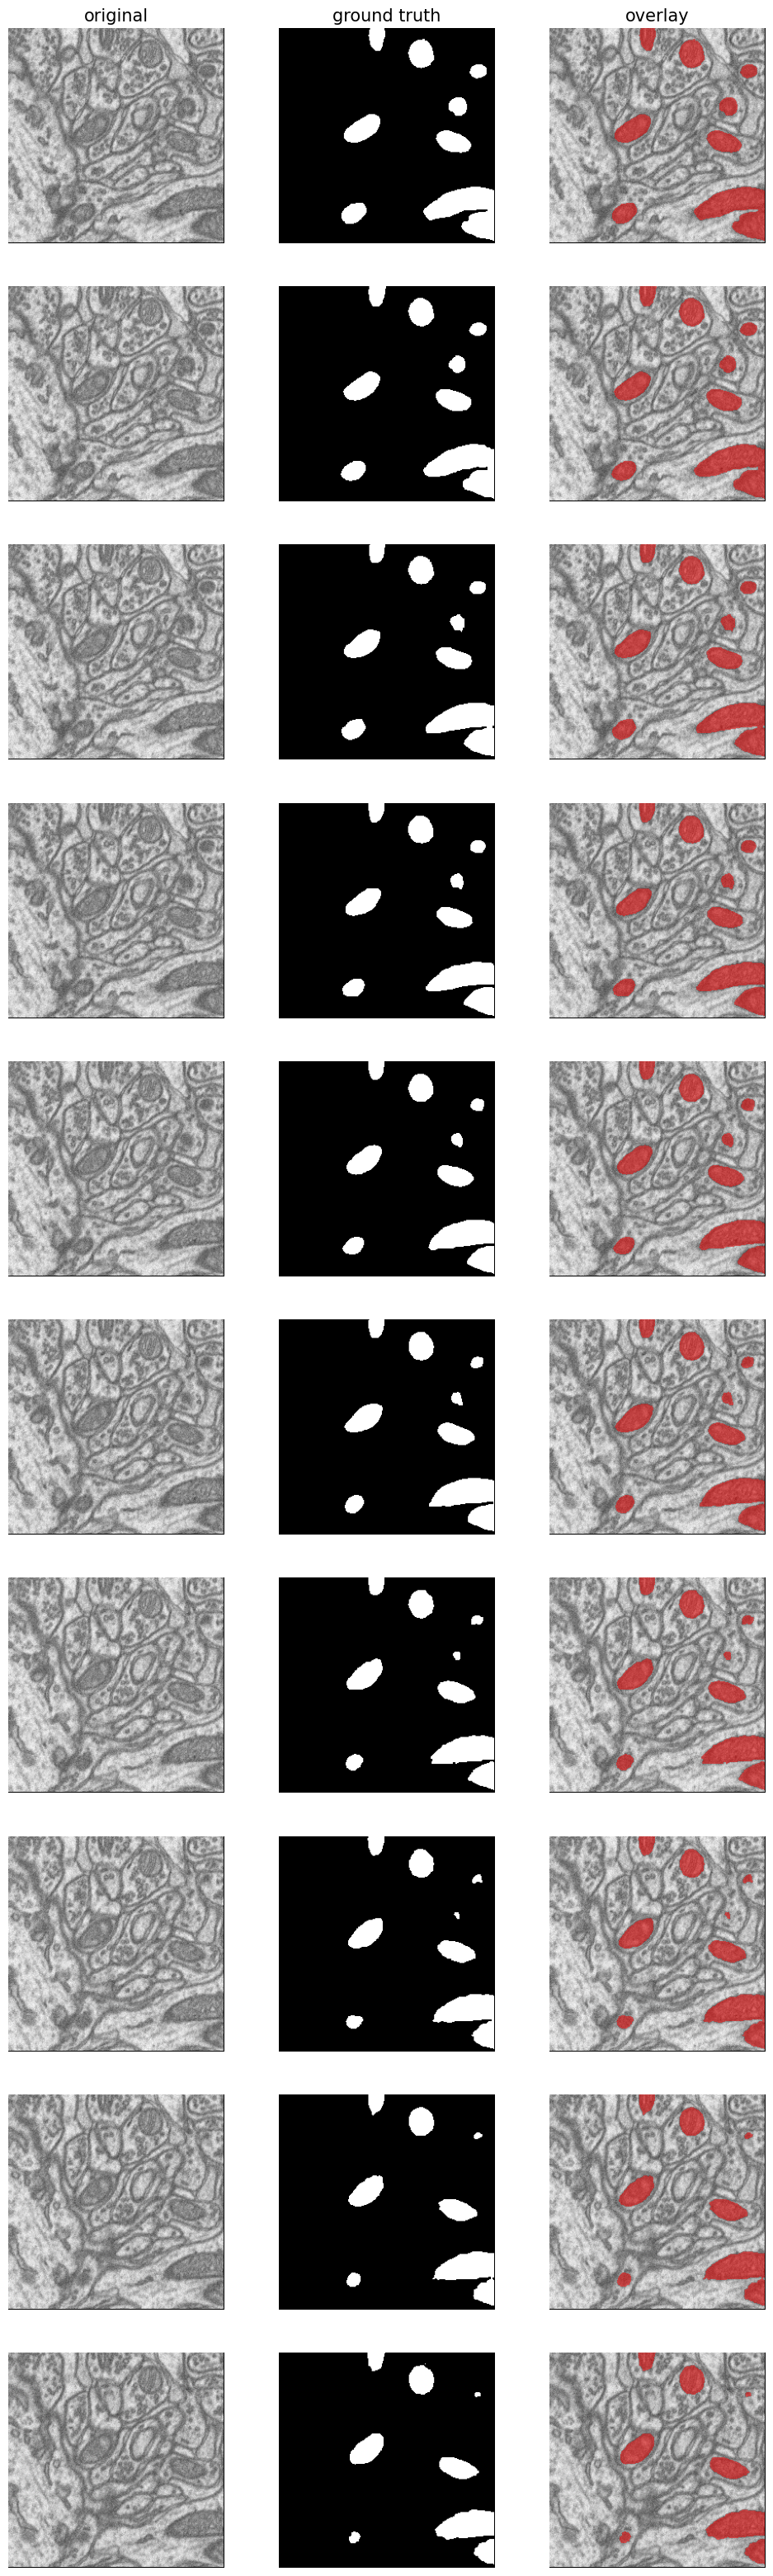

In [24]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [25]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [26]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE

# convert to float32
images = images.astype(np.float32)

# normalize to the range of 0..1
images /= images.max()

# Add the last channel using .reshape like in class
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

# assign to X variable
X = images

In [27]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [28]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [29]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE

# convert to bool
masks = masks.astype(bool)

# Add the last channel using .reshape like in class
masks = masks.reshape(masks.shape[0], masks.shape[1], masks.shape[2], 1)

# assign to y variable
y = masks


In [30]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [31]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [34]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [35]:
# TODO: Why do we call train_test_split twice?
# TODO: The train_test_split is called twice in order to split the data into three sets: training, testing and validation. The first time it splits into training set an testing set, the second time the training set is splits into training set and validation set. 

In [36]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [37]:
# TODO: Please explain the code from above.
# TODO: This code performs data augmentation on the training data. 
## get_augmented is a function that takes four arguments 
## X_train, y_train which are input images and masks respectively 
## batch_size is sample size used during training
## data_gen_args is arguments to pass to the data augmentation
##  rotation_range is the rotation angle, width_shift_range= fraction of width, height_shift_range is fraction of height
## this code applies random transformations to images and their masks before it is inputted to the model. This helps the model to train efficiently even for new and unseen data. 

(2, 256, 256, 1) (2, 256, 256, 1)


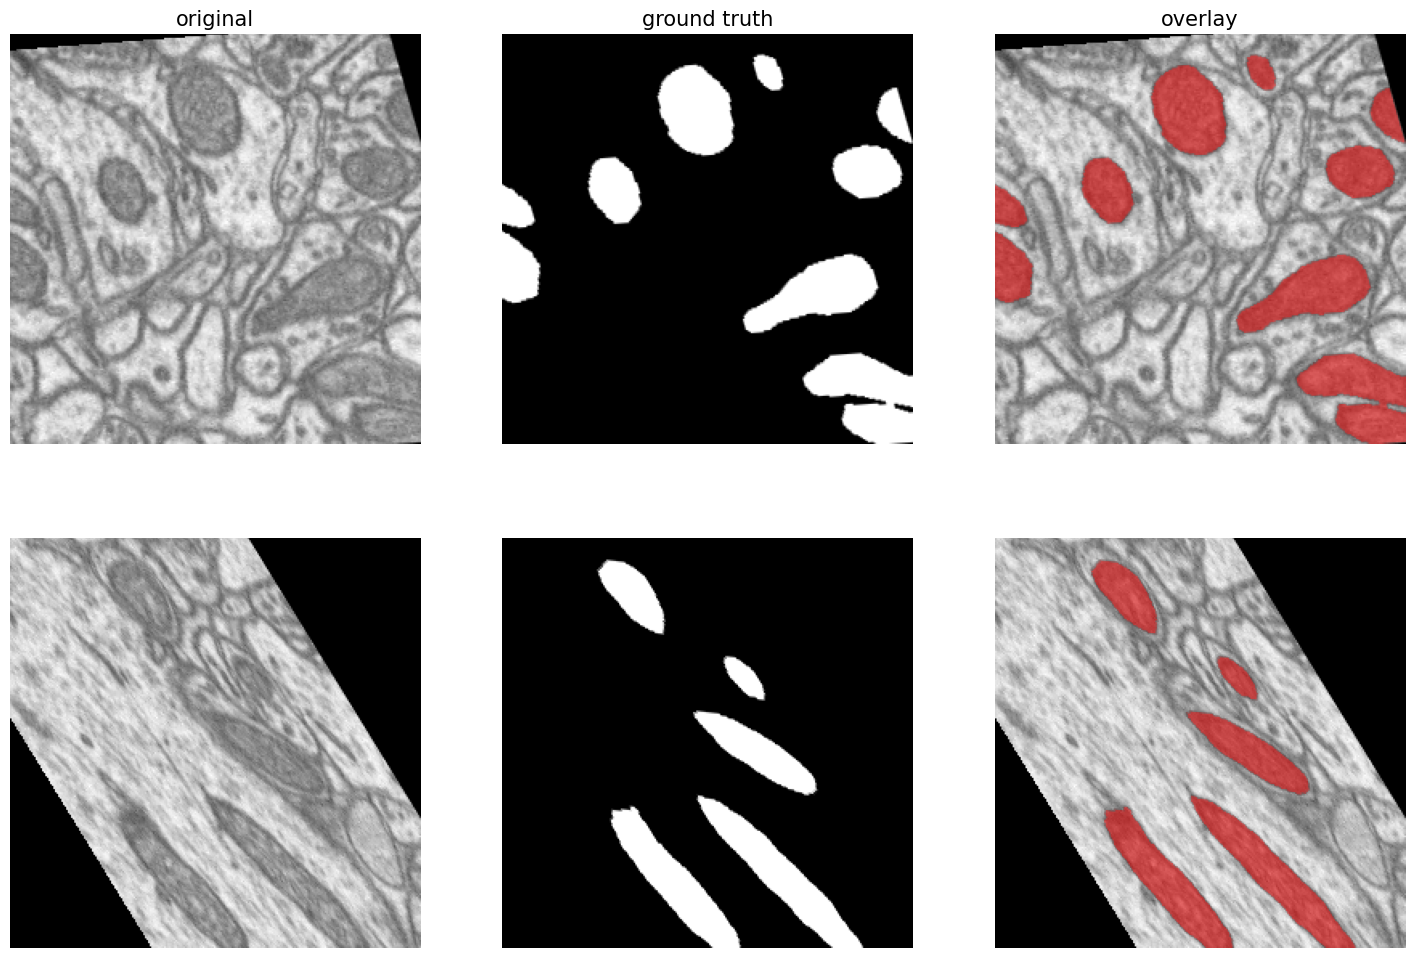

In [38]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [39]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [41]:
# TODO: How many  trainable parameters does the model use?
# TODO: Approximately 3 million parameters 

In [42]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [43]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [44]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: IoU finds similarity between two sets by calculating the ratio of area of intersection to the area of their union between two sets. 

In [45]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
train_gen,
steps_per_epoch=len(X_train),
epochs=30,
validation_data=(X_val, y_val)
)

Epoch 1/30
369/369 [==============================] - 109s 272ms/step - loss: 0.2204 - iou: 0.0673 - iou_thresholded: 2.0062e-04 - val_loss: 0.2039 - val_iou: 0.0964 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 57s 155ms/step - loss: 0.1608 - iou: 0.1633 - iou_thresholded: 0.1211 - val_loss: 0.1454 - val_iou: 0.2623 - val_iou_thresholded: 0.3636
Epoch 3/30
369/369 [==============================] - 58s 156ms/step - loss: 0.1145 - iou: 0.3139 - iou_thresholded: 0.3926 - val_loss: 0.1103 - val_iou: 0.3326 - val_iou_thresholded: 0.3695
Epoch 4/30
369/369 [==============================] - 57s 155ms/step - loss: 0.1066 - iou: 0.3397 - iou_thresholded: 0.3955 - val_loss: 0.0754 - val_iou: 0.5125 - val_iou_thresholded: 0.6673
Epoch 5/30
369/369 [==============================] - 57s 155ms/step - loss: 0.0777 - iou: 0.4757 - iou_thresholded: 0.5929 - val_loss: 0.0573 - val_iou: 0.6327 - val_iou_thresholded: 0.7328
Epoch 6/30
369/369 [================

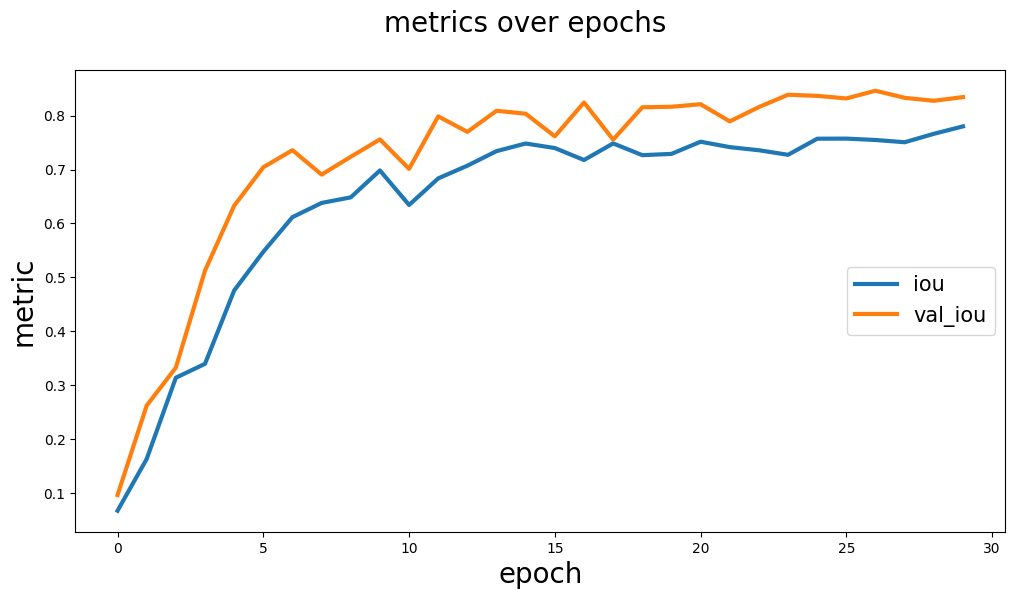

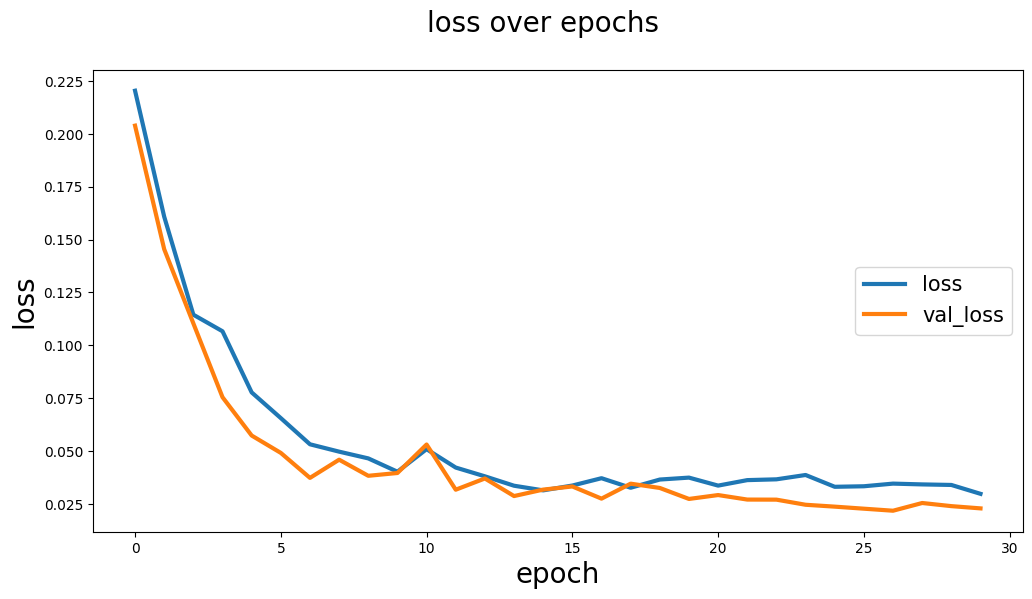

In [46]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [47]:
# TODO: Do these plots look good to you?
# TODO: YES

## 3. Evaluate U-Net (10 points)

In [48]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 4s 1s/step


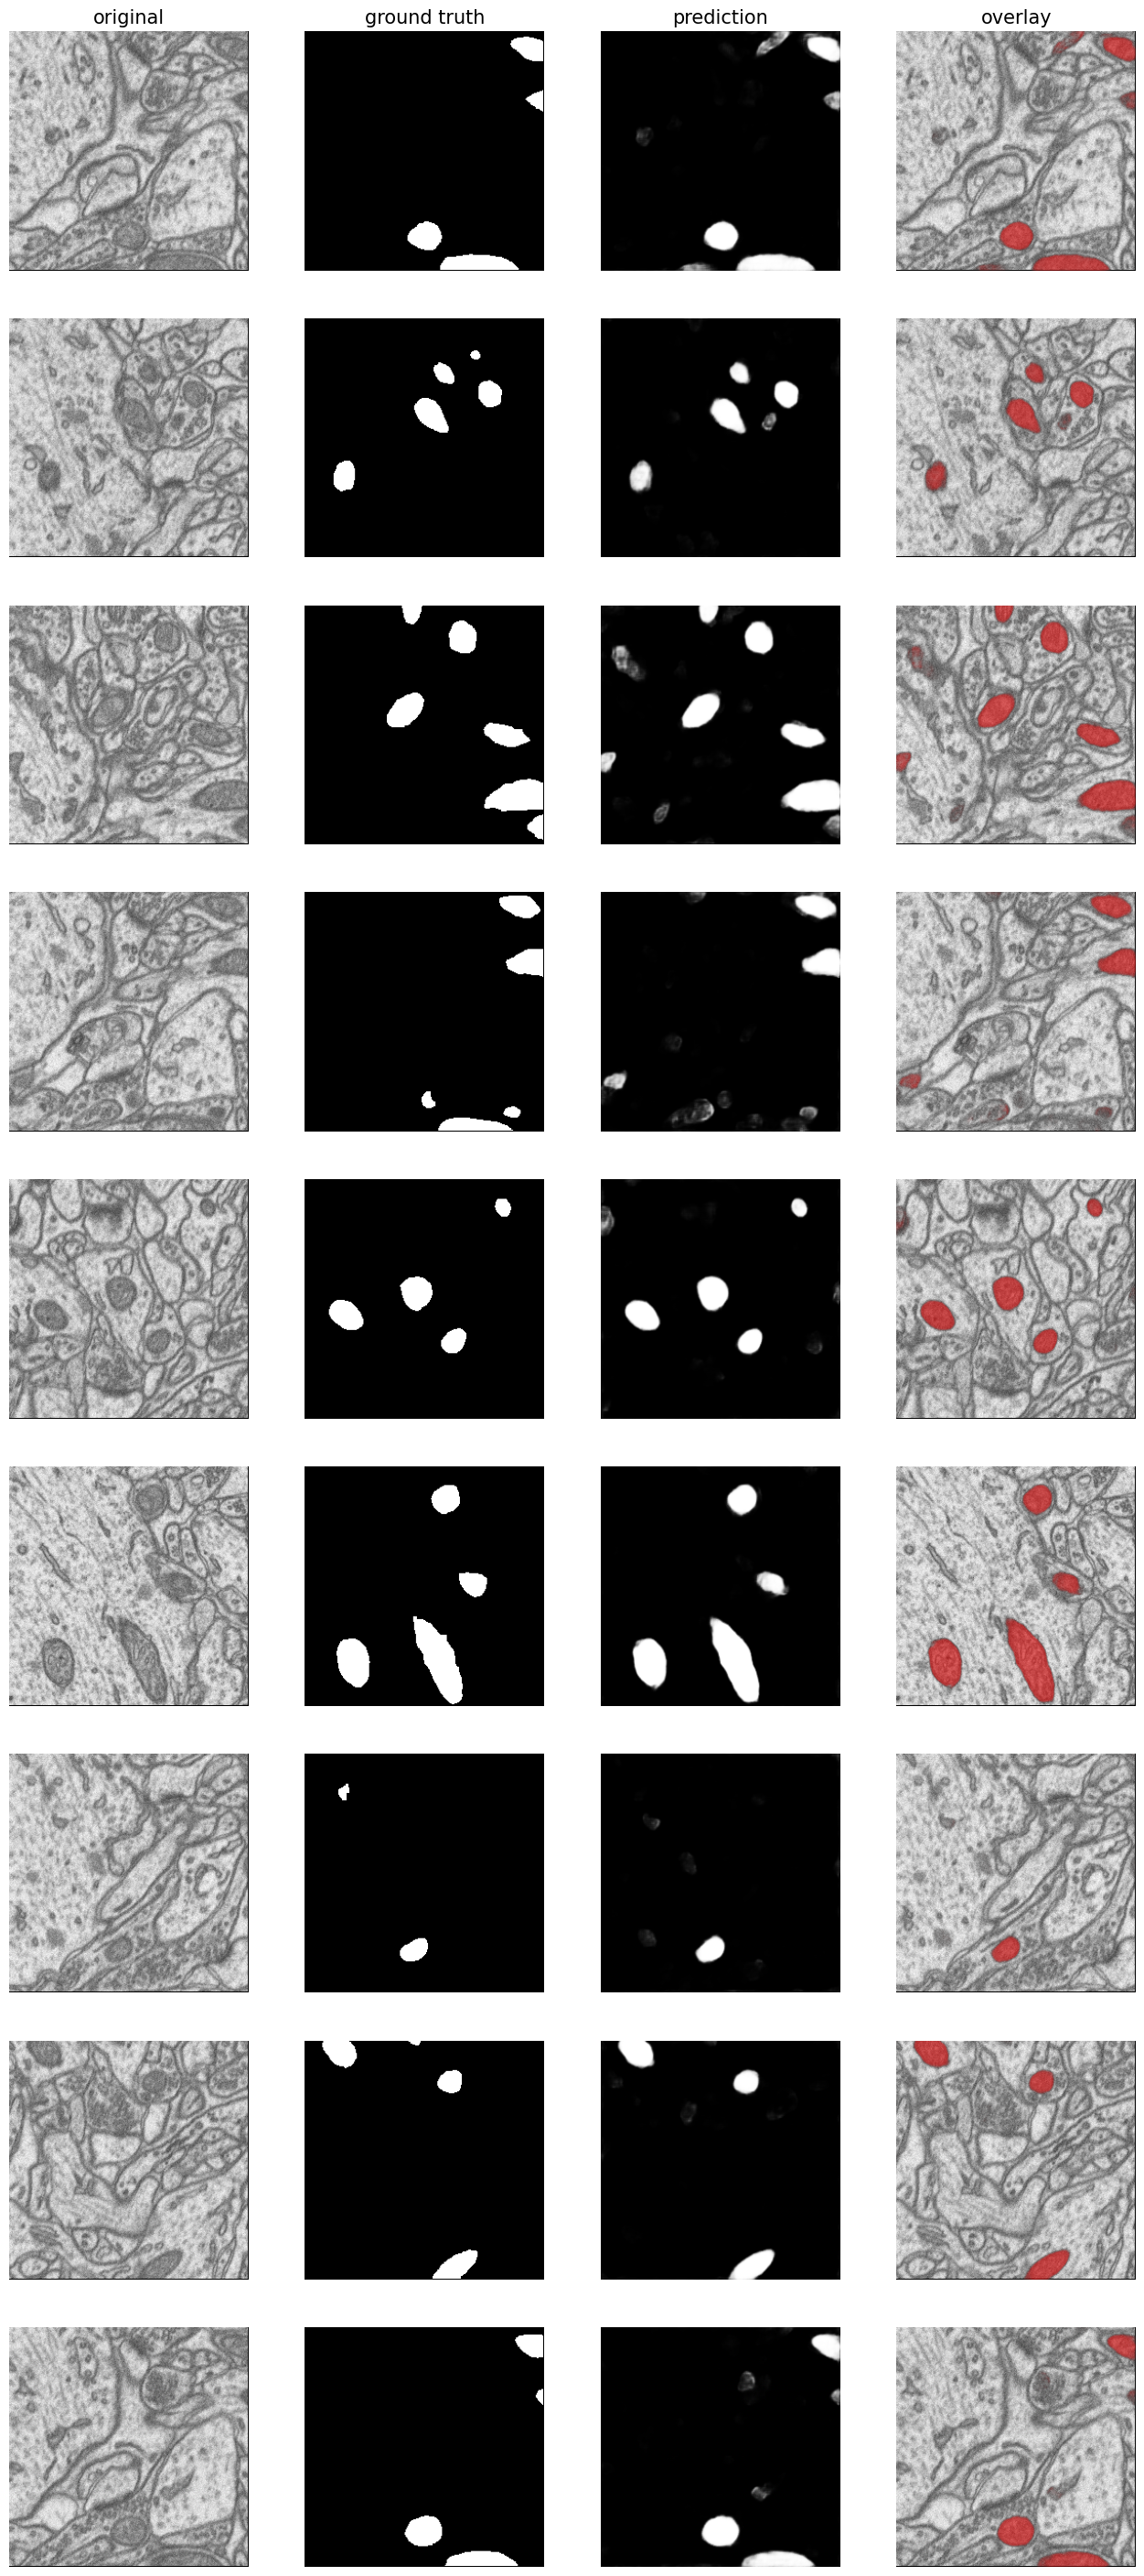

In [49]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [50]:
import sklearn.metrics

In [51]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8895037576538439

In [52]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: Jaccard score compares the binary thresholded y_pred values to y_test values, IoU finds the similarity between two sets by calculating the ratio of area of intersection to area of union between two sets. 

In [53]:
# TODO: Did the U-Net perform well on X_test?
# TODO: Yes it performs well on X_test

## 4. Combine U-Net with SAM (10 points)

In [54]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [55]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [56]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [57]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [58]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [59]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: saves first channel of input image as PNG file named as test.png, it is multiplied by 255 to scale the pixel values. 
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: checking whether the predicted value of a binary classification model is greater than 0.5. Returns boolean value.
  pred = (y_pred[z] > 0.5)

  # TODO: labels a binary image. Pred is a 2D array where each component of the binary image is labeled with a unique integer
  pred, _ = mh.labeled.label(pred)
  
  # TODO: bbox computes the minimum bounding box for each component of the binary image, bbs will be a list of tuples containing bounding boxes. 
  bbs = mh.labeled.bbox(pred)

  # TODO: converts bbs to a different format to be passed to SAM 
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: image segmentation into different regions and segments. The image.predict function uses parameters
  results = SegManualMaskPredictor().image_predict(
      source="test.png",  ## source image
      model_type="vit_l", # vit_l, vit_h, vit_b 
      input_box=bbs_converted, ## list of bounding boxes 
      multimask_output=False,  ##a boolean flag 
      random_color=False,  ## random color for each segmented part
      show=False, ## boolean whether to display the image 
      save=False,  ## a boolean flag whether to save the segmented image
  )

  # TODO: converts the output to SAM format 
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: assigns the output of sam_and_unet_pred to a specific slice of  y_pred_sam 4D array 
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [60]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8895037576538439

In [61]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.861722527806885

In [62]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: It is a good addition but no significant improvement. 

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [ ]:
# TODO: YOUR_CO

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#